### Segmenting the Right-of-Way for San Francisco
***Using VGG16-UNET on RGB Satellite Imagery***

**MUSA 650 Final Project** – *Alexander Nelms*

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;For my final project, I will be performing right-of-way semantic segmentation of satellite imagery. I want to understand which areas of the City of San Francisco are roads/right-of-way. My training/mask dataset is a Right-of-Way polygons that define the drivable area in the city. The satellite imagery is from the National Agriculture Imagery Program and has 4 bands: Red, Green, Blue, & Infrared.

## Introduction

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;It is financially and administratively difficult for the GIS departments of American cities to constantly update basic datasets. One large dataset that is rarely create or update is Right-of-Way polygons – even though many public and private stakeholders lean on that dataset to understand other urban trends. When looking at satellite imagery, it is easy for the human eye to classify what surfaces are asphalt, where the curb/sidewalk starts, and what isn’t a road. With that in mind, I want to use semantic segmentation on satellite imagery to classify areas that are the right-of-way. 

In [1]:
# PACKAGES & DIRECTORIES
import os
import pandas as pd
import geopandas as gpd

DIRECTORY = r'C:\Users\nelms\Documents\Penn\MUSA-650\FinalProject'
DIR = DIRECTORY
PROJ_DIR = DIR
DATA_DIR = os.path.join(PROJ_DIR, 'data')
ZIP_DIR = os.path.join(DATA_DIR, 'raw', 'NAIP')

os.chdir(PROJ_DIR)

tiff_proj = 'EPSG:26910'

feet2meter = 0.3048
ft2m = feet2meter

C:\Users\nelms\Documents\Penn\MUSA-650\FinalProject


## Data

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;My data cleaning process is to (1) use multiband, higher resolution satellite imagery (.5 meter) as the input data of a neural network and (2) right-of-way polygons as the ground truth data. I will be focusing on San Francisco since the city’s GIS team has a fairly clean and updated right-of-way polygon dataset. I will cut the right-of-way polygons then only select the fishnet cells that don’t contain right-of-way polygons that are on freeways or in underground tunnels. The fishnet cells of right-of-way polygons will then be transformed to TIFs of equal size of the satellite imagery. 

In [ ]:
# SAN FRANCISCO LAND REFERENCE DATA
project_crs = 'EPSG:7132'
CAPSTONE_DATA_FOLDER = r'C:\Users\nelms\Documents\Penn\CPLN-680\Permit_Metrics\data'
CAPSTONE_CLEAN_FOLDER = CAPSTONE_DATA_FOLDER + r'\clean'
path = CAPSTONE_CLEAN_FOLDER + r'\sf_2010censusblock.geojson'
sfblock = gpd.read_file(path).to_crs(project_crs)
sftract = sfblock.dissolve(by='geoid10').reset_index(drop=False).drop('block_id', 1)
sf_landform = sfblock.unary_union
sf_landform = gpd.GeoDataFrame(geometry=[sf_landform], crs=project_crs).to_crs(tiff_proj)

# SAN FRANCISCO COUNTY DATA
path = r"C:\Users\nelms\Documents\Penn\CPLN-675\HW5\data\sf_counties_clipped.geojson"
sf_counties = gpd.read_file(path)

sf_fip = '075'
non_sf = sf_counties[sf_counties['fipco']!=sf_fip].to_crs(tiff_proj)
non_sf = non_sf['geometry'].unary_union

# SAN FRANCISCO RIGHT-OF-WAY DATA
#path = os.path.join(DATA_DIR, 'raw', 'sf_row_polys.geojson')
#sfrow = gpd.read_file(path).to_crs(tiff_proj)
#sfrow = sfrow['geometry'].unary_union
##intersect_geom = intersect_gdf['geometry'].unary_union
##sfrow = sfrow.intersection(intersect_geom)
#from shapely.ops import unary_union
#sfrow = unary_union(sfrow.buffer(.5)).buffer(-4)

sfrow_path = os.path.join(DATA_DIR, 'clean', 'sfrow_cleaned.geojson')
sfrow = gpd.read_file(sfrow_path).geometry.values[0]
#gpd.GeoDataFrame(geometry=[sfrow], crs=tiff_proj).to_file(sfrow_path)

# ROAD CENTERLINES
## Import OSMnx
import osmnx as ox

#sf_g = ox.graph_from_place("San Francisco, CA", network_type='drive')
#sf_g = ox.project_graph(sf_g, to_crs=tiff_proj)
#_, edges_gdf = ox.graph_to_gdfs(
#        sf_g,
#        nodes=True, edges=True,
#        node_geometry=True,
#        fill_edge_geometry=True)

edge_path = os.path.join(DATA_DIR, 'clean', 'sf_centerline_20220502.geojson')
edges_gdf = gpd.read_file(edge_path)

#edges_gdf = gpd.overlay(edges_gdf, y_gdf[['geometry']], how='intersection')

#tun_filt = (edges_gdf['tunnel'].isna())
#edges_gdf = edges_gdf[~tun_filt]

#remove_hwy = ['unclassified', 'motorway_link', 'primary_link']
#list_filt = edges_gdf['highway'].apply(type) == list
#def remove_lists(hlist, remove_list = remove_hwy):
#    filt_list = [h for h in hlist if h not in remove_list]
#    if len(filt_list) == 0:
#        filt_list = hlist
#    return filt_list[0]
#edges_gdf.loc[list_filt, 'highway'] = edges_gdf.loc[list_filt, 'highway'].apply(remove_lists)

#hwy_filt = (edges_gdf['highway'].str.contains('motorway'))
#edges_gdf['hwy'] = False
#edges_gdf.loc[hwy_filt, 'hwy'] = True
#edges_gdf.loc[edges_gdf['bridge']=='yes', 'bridge'] = True

#br_list_filt = edges_gdf['bridge'].apply(type) == list
#edges_gdf.loc[br_list_filt, 'bridge'] = True
#edges_gdf.loc[edges_gdf['bridge']=='movable', 'bridge'] = True

#tunnel_filt = (~edges_gdf['tunnel'].isna())
#edges_gdf.loc[tunnel_filt, 'tunnel'] = True

#est_lanes = 2
#edges_gdf['lanes'] = edges_gdf['lanes'].fillna(value = est_lanes)
#edges_gdf['lanes'] = \
#    edges_gdf['lanes'] \
#        .apply(lambda lanes: [lanes] if type(lanes)!=list else list(lanes)) \
#        .apply(lambda lanes: sum(list([int(l) for l in lanes])))

#row_buffer = 1
#edges_gdf['road_width'] = (edges_gdf['lanes'] * 12 * ft2m) + row_buffer*ft2m

#edges_gdf.reset_index(drop=True)[['lanes', 'highway', 'bridge', 'tunnel', 'hwy', 'road_width', 'geometry']].to_file(edge_path)

# FILTER 
no_tunnel = (edges_gdf['tunnel'].isna())
is_hwy = (edges_gdf['hwy']==True)
is_bridge = (edges_gdf['bridge']==True)
is_hwybridge = is_hwy|is_bridge

hwybridge_gdf = edges_gdf[no_tunnel&is_hwybridge].copy()
hwybridge_gdf['geometry'] = hwybridge_gdf['geometry'].buffer(hwybridge_gdf['road_width']+5*feet2meter)
hwybridge_gdf = hwybridge_gdf['geometry'].unary_union

roads_gdf = edges_gdf[no_tunnel&(~is_hwybridge)].copy()
roads_gdf['geometry'] = roads_gdf['geometry'].buffer(roads_gdf['road_width'])
roads_gdf = roads_gdf['geometry'].unary_union

### X Data: Satellite Images

My primary dataset is satellite images of San Francisco from the National Agriculture Imagery Program. This dataset is extremely valuable as it has:
1. 4 bands: Red, Green, Blue, & Infrared
2. a .5 meter resolution
3. Relatively low amounts of cloud cover
4. Images for every other year (2012-2020)

In [24]:
# UNZIP THE SATELLITE IMAGES

zip_locations = [(root,dirnames,filenames) for root,dirnames,filenames in os.walk(ZIP_DIR)][0][2]
zip_locations[0:5]

from skimage.io import imread, imshow
import rasterio as rio

from io import BytesIO
from zipfile import ZipFile
import numpy as np

# GET POLYGON BOUNDARY BOX
from shapely.geometry import box
# bounds to box 
def bound_to_poly(b_list):
    #ymin, ymax, xmin, xmax = b_list
    left, right, bottom, top = b_list
    width = right-left
    height = top-bottom
    b_list = [
        left,
        top,
        width,
        height
    ]
    return box(b_list[0], b_list[1], b_list[0] + b_list[2], b_list[1] - b_list[3]) #Polygon(zip(b_list))

from tqdm import tqdm

years = [2016, 2018, 2020]

# PIXEL SIZE
def spatial_resolution(raster):
    """extracts the XY Pixel Size"""
    t = raster.transform
    x = t[0]
    y =-t[4]
    return x, y

# CONVERT IMAGE TO RASTER.IO
def get_raster_info(landsat):
    #landsat = rio.open(file_path)
    meta = landsat.meta # dict of meata
    proj = meta['crs'].data['init'] # get proj string
    bounds = bound_to_poly([  # Set the extent of the images
        landsat.bounds.left,
        landsat.bounds.right,
        landsat.bounds.bottom,
        landsat.bounds.top
    ])
    bands = landsat.indexes # band amount & count
    shape = landsat.shape   # shape of raster
    resolution = spatial_resolution(landsat) # pixel size
    transform = landsat.transform
    landsat = landsat.read()
    
    return [landsat, transform, proj, bounds, bands, shape, resolution, meta]

# OPEN ZIPS, CONVERT IMAGES TO RASTER, AND STORE RASTERS IN A DATAFRAME
img_list = []
image_types = ['.tif'] #['.jpg', '.png', '.tif']
# loop through each zip location
for zip_path in tqdm(zip_locations):
    # full zip path
    full_zip_path = os.path.join(ZIP_DIR, zip_path)
    # open zip
    with ZipFile(full_zip_path, mode="r") as zip_contents:
        # list of zip contents
        for entry in zip_contents.infolist():
            # only look if an image
            ## specifically .tif
            if any(img for img in image_types if img in entry.filename):
                # open image
                if any(year for year in years if str(year) in entry.filename):
                    with zip_contents.open(entry) as file:
                        # open as rasterio dataset
                        with rio.open(file) as dataset:
                            # make list/row with name, raster dataset, & info
                            file_list = [entry.filename] + get_raster_info(dataset)
                            img_list.append(file_list)
# convert lists to dataframe
cols = ['filename', 'raster', 'transform', 'proj', 'bounds', 'bands', 'shape', 'resolution', 'meta']
img_df = pd.DataFrame(img_list, columns=cols)

100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [03:33<00:00,  5.07s/it]


The narrow resolution will be helpful in getting accurate estimates of the RoW and being able to turn those predictions into polygons to be used. 

In [ ]:
# DATES
# get date of each image
img_df['date'] = img_df['filename'].str.split('_').apply(lambda dt: dt[-1].split('.')[0])
img_df['date'] = pd.to_datetime(img_df['date'])
# year
img_df['year'] = img_df['date'].dt.year
img_df.head(3)

,filename,raster,transform,proj,bounds,bands,shape,resolution,meta,mask,non_sf,water,hwy,roads,date,year
0,m_3712212_se_10_060_20180804.tif,"[[[42, 40, 38, 39, 43, 49, 42, 67, 94, 108, 84...","(0.6, 0.0, 538356.0, 0.0, -0.6, 4185282.0, 0.0...",epsg:26910,"POLYGON ((544200 4185282, 544200 4178016, 5383...","(1, 2, 3, 4)","(12110, 9740)","(0.6, 0.6)","{'driver': 'GTiff', 'dtype': 'uint8', 'nodata'...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2018-08-04,2018
1,m_3712212_se_10_060_20200524.tif,"[[[176, 181, 128, 129, 122, 134, 113, 75, 65, ...","(0.6, 0.0, 538308.0, 0.0, -0.6, 4185330.0, 0.0...",epsg:26910,"POLYGON ((544248 4185330, 544248 4177968, 5383...","(1, 2, 3, 4)","(12270, 9900)","(0.6, 0.6)","{'driver': 'GTiff', 'dtype': 'uint8', 'nodata'...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2020-05-24,2020
2,m_3712212_se_10_h_20160625.tif,"[[[39, 40, 40, 41, 42, 41, 41, 40, 39, 40, 40,...","(0.6, 0.0, 538356.0, 0.0, -0.6, 4185282.0, 0.0...",epsg:26910,"POLYGON ((544200 4185282, 544200 4178016, 5383...","(1, 2, 3, 4)","(12110, 9740)","(0.6, 0.6)","{'driver': 'GTiff', 'dtype': 'uint8', 'nodata'...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2016-06-25,2016


I ultimately only used 2018 data as bringing also bringing in the 2016 & 2020 images would: 
1. make processing even heavier
2. potentially make the model overfit on the same San Francisco streets

<AxesSubplot:>

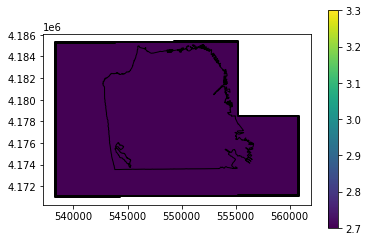

In [ ]:
tiff_proj = img_df['proj'].values[0]
img_gdf = gpd.GeoDataFrame(img_df, crs=tiff_proj, geometry = img_df['bounds'])

from shapely.ops import unary_union
y_gdf = img_df.groupby('year').agg({
    'bounds':unary_union, 'resolution':'first', 'bands':'first', 'filename':'count', 'date':'first'
})
y_gdf = gpd.GeoDataFrame(y_gdf, crs=tiff_proj, geometry = y_gdf['bounds']) \
    .drop(columns='bounds')

# get overlapping counts
## from stack overflow
## https://gis.stackexchange.com/questions/387773/count-overlapping-features-using-geopandas
def count_overlapping_features(in_gdf):
    import shapely
    # Get the name of the column containing the geometries
    geom_col = in_gdf.geometry.name
    
    # Setting up a single piece that will be split later
    input_parts = [in_gdf.unary_union.buffer(0)]
    
    # Finding all the "cutting" boundaries. Note: if the input GDF has 
    # MultiPolygons, it will treat each of the geometry's parts as individual
    # pieces.
    cutting_boundaries = []
    for i, row in in_gdf.iterrows():
        this_row_geom = row[geom_col]
        this_row_boundary = this_row_geom.boundary
        if this_row_boundary.type[:len('multi')].lower() == 'multi':
            cutting_boundaries = cutting_boundaries + list(this_row_boundary.geoms)
        else:
            cutting_boundaries.append(this_row_boundary)
    
    
    # Split the big input geometry using each and every cutting boundary
    for boundary in cutting_boundaries:
        splitting_results = []
        for j,part in enumerate(input_parts):
            new_parts = list(shapely.ops.split(part, boundary).geoms)
            splitting_results = splitting_results + new_parts
        input_parts = splitting_results
    
    # After generating all of the split pieces, create a new GeoDataFrame
    new_gdf = gpd.GeoDataFrame({'id':range(len(splitting_results)),
                                geom_col:splitting_results,
                                },
                               crs=in_gdf.crs,
                               geometry=geom_col)
    
    # Find the new centroids.
    new_gdf['geom_centroid'] = new_gdf.centroid
    
    # Starting the count at zero
    new_gdf['count_intersections'] = 0
    
    # For each of the `new_gdf`'s rows, find how many overlapping features 
    # there are from the input GDF.
    for i,row in new_gdf.iterrows():
        new_gdf.loc[i,'count_intersections'] = in_gdf.intersects(row['geom_centroid']).astype(int).sum()
        pass
    
    # Dropping the column containing the centroids
    new_gdf = new_gdf.drop(columns=['geom_centroid'])[['id','count_intersections',geom_col]]
    
    return new_gdf

intersect_gdf = count_overlapping_features(y_gdf[y_gdf.index>=2016])
intersect_gdf

# PLOT
img_gdf = gpd.GeoDataFrame(img_df, crs=img_df['proj'].values[0], geometry = img_df['bounds'])
#ax = img_gdf.plot(alpha=.5, column='year', ec='black', lw=2, legend=True)
ax = intersect_gdf.plot(column='count_intersections', ec='black', lw=2, legend=True)
sf_landform.plot(ax=ax, zorder=8, color='None')

### Y Data: Right-of-Way Mask

The actual Right-of-Way (RoW) mask for the Deep Learning model is polygons of drivable streets in San Francisco. Originally from SF's [Open Data Portal](https://data.sfgov.org/City-Infrastructure/Right-of-Way-Polygons/a2mg-gwmg).

The dataset was hand made by the City of San Francisco over the course of 2016 and 2019. A single GIS Analyst or team handdrawing this dataset helps makes this dataset a fairly good quality overall. An issue with human error & team editing is that the definition of 'Right-of-Way' can slightly change throughtout the dataset. Most RoW polygons include the automobile traffic lanes; however, the polygons are *inconsistent* when considering:
* bike lanes, 
* parking spots, 
* highways, and
* sidewalks. 

In [25]:
from shapely.geometry import MultiPolygon, Polygon
from rasterio.mask import mask

def polyToMask(shape, transform, polys=sfrow, default_value = 1,
        fill=0, all_touched = False):
    raster_poly = rio.features.rasterize(
        [polys], 
        out_shape=shape,
        transform=transform,
        all_touched = all_touched,
        default_value = default_value,
        fill=fill
        )
    return raster_poly

img_df['mask'] = img_df.apply(lambda row: polyToMask(row['shape'], row['transform'], polys=sfrow.intersection(row['bounds'])), axis=1)

Because of the slight inconsistencies with the RoW polygons, I will bring in a road centerline dataset to sort of 'ground truth' the cut RoW polygons.

### Filter & Data Quality Masks

Because of the slight variety in the RoW polygons and the fairly large satellite images, I will create geographic *masks* and *filters* that target certain cut areas that:
* have RoW polygons *when there is supposed to be*, and 
* remove excess satellite images.

To accomplish this, I will bring in fiters that locate
1. unincorporated/non-SF land, 
2. water *(primarily the Pacific Ocean)*,
3. highways & bridges *that aren't represented in the RoW polygons*, and
4. road centerlines *that will estimate how correct the RoW polygons are*.

##### 1. Unincorporated Land
Determine which area of land is not in the city of san francisco (and won't have an RoW mask). The land polygon is Bay Area counties boundaries *(that aren't SF)* that are clipped by water, from the San Francisco Regional [Open Data Portal](https://opendata.mtc.ca.gov/datasets/MTC::san-francisco-bay-region-counties-clipped-1/explore?location=37.833940%2C-122.344500%2C9.36).

In [26]:
img_df['non_sf'] = img_df.apply(
    lambda row: 
    polyToMask(
        row['shape'], 
        row['transform'], 
        polys=non_sf,
        default_value = 1,
        fill=0
        ), 
    axis=1)

##### 2. Water
Water areas that cannot have RoW. It just considers areas that are not in the SF County boundary that is clipped by water, from the San Francisco Regional [Open Data Portal](https://opendata.mtc.ca.gov/datasets/MTC::san-francisco-bay-region-counties-clipped-1/explore?location=37.833940%2C-122.344500%2C9.36).

In [27]:
mile10 = 16093.4
land = sf_landform.to_crs(tiff_proj).geometry[0]
water = land.buffer(mile10)
land = unary_union([land, non_sf])
water = water.symmetric_difference(land).intersection(water)

land = sf_landform.to_crs(tiff_proj).geometry[0]
img_df['water'] = img_df.apply(
    lambda row: 
    polyToMask(
        row['shape'], 
        row['transform'], 
        polys=water.intersection(row['bounds']),
        default_value = 1,
        fill=0
        ), 
    axis=1)

##### 3. Highways & Bridge Centerlines
Highways & Bridges aren't in the RoW polygons. The centerlines are imported from Open Street Map *(via OSMnx)*, buffered by street lanes *(assuming ~12ft wide)*, then filtered by Highway & Bridge types.

In [29]:
img_df['hwy'] = img_df.apply(
    lambda row: 
    polyToMask(
        row['shape'], 
        row['transform'], 
        polys=hwybridge_gdf.intersection(row['bounds']),
        default_value = 1,
        fill=0
        ) if not hwybridge_gdf.intersection(row['bounds']).is_empty 
    else np.zeros(row['shape']), 
    axis=1)

##### 4. Drivable Road Centerlines
I wanted to bring in road centerlines to detect defects in the RoW polygons. The centerlines are imported from Open Street Map *(via OSMnx)*, buffered by street lanes *(assuming ~12ft wide)*, then filtered by non-Highway, Bridge, & Tunnel road types.

In [30]:
img_df['roads'] = img_df.apply(
    lambda row: 
    polyToMask(
        row['shape'], 
        row['transform'], 
        polys=roads_gdf.intersection(row['bounds']),
        default_value = 1,
        fill=0
        ), 
    axis=1)

### Plot of Mask

m_3712212_se_10_060_20180804.tif
m_3712213_se_10_060_20180804.tif
m_3712213_sw_10_060_20180804.tif
m_3712220_ne_10_060_20180804.tif
m_3712221_ne_10_060_20180804.tif
m_3712221_nw_10_060_20180804.tif
m_3712222_nw_10_060_20180723.tif


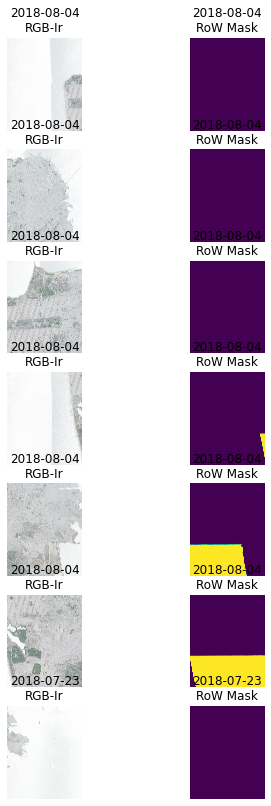

In [35]:
from rasterio.plot import show
import random

pot_files = [
    f for f in img_df['filename'].unique() 
    #if f not in good
    if str(2018) in f
    ]

preview = 3
ints = [random.randint(0, len(pot_files)-1)]

import matplotlib.pyplot as plt
cols, rows = 2, len(pot_files)
axes = []
[[axes.append((c,r)) for r in range(rows)] for c  in range(cols)]
axis_count = len(axes)
fig, ax = plt.subplots(rows, cols, figsize=[6,14])

for row in range(rows):
    idx = pot_files[row]
    #date, filename, test_img, raster_img = img_df[img_df['filename']==idx][['date', 'filename', 'raster', 'mask']].values[0]
    date, filename, test_img, raster_img = img_df[img_df['filename']==idx][['date', 'filename', 'raster', 'non_sf']].values[0]

    ax[row, 0].imshow(test_img.transpose([1,2,0]))
    ax[row, 0].set_title(str(date).split(' ')[0] + '\n' + 'RGB-Ir')
    ax[row, 0].set_axis_off()
    ax[row, 1].imshow(raster_img)
    ax[row, 1].set_title(str(date).split(' ')[0] + '\n' + 'RoW Mask')
    ax[row, 1].set_axis_off()
    print(filename)

## Cut

### Determine if to Cut Image from the Left or Right, Bottom or Top

In [36]:
right_start = [
    'm_3712220_ne_10_060_20200524.tif',
    'm_3712212_se_10_060_20180804.tif',
    'm_3712212_se_10_060_20200524.tif',
    'm_3712212_se_10_h_20160625.tif',
    'm_3712220_ne_10_060_20180804.tif',
    'm_3712220_ne_10_h_20160625.tif',
    'm_3712221_nw_10_060_20180804.tif',
    'm_3712221_nw_10_060_20200524.tif',
    'm_3712221_nw_10_h_20160625.tif'
]
bottom_start = [
    'm_3712212_se_10_060_20180804.tif',
    'm_3712212_se_10_060_20200524.tif',
    'm_3712212_se_10_h_20160625.tif',
    'm_3712213_se_10_060_20180804.tif',
    'm_3712213_se_10_060_20200524.tif',
    'm_3712213_se_10_h_20160625.tif',
    'm_3712213_sw_10_060_20180804.tif',
    'm_3712213_sw_10_060_20200524.tif',
    'm_3712213_sw_10_h_20160625.tif'
]
checked = [
    'm_3712222_nw_10_h_20160531.tif',
    'm_3712222_nw_10_060_20200524.tif',
    'm_3712221_ne_10_060_20180804.tif',
    'm_3712221_ne_10_060_20200524.tif',
    'm_3712221_ne_10_h_20160625.tif',
    'm_3712222_nw_10_060_20180723.tif'
]
good = set(right_start + bottom_start + checked)

img_df['start_right'] = False
img_df.loc[img_df['filename'].isin(right_start), 'start_right'] = True

img_df['start_bottom'] = False
img_df.loc[img_df['filename'].isin(bottom_start), 'start_bottom'] = True

### Functions

In [37]:
# gets the start & stop pairs 
## based on the steps (cut size) and the possible parts
## initial/off-set start based on start from left-right, top-bottom
def get_index_pairs(parts, step = 64, initial_start = 0):
    indexes=[]
    start = 0 + initial_start
    for _ in range(parts):
        stop = start + step
        index = (start, stop)
        indexes.append(index)
        start = stop
    return indexes

# get the index pairs for both the height & width of an array
## considers starting at the bottom or right sides
def height_width_pairs(
    whb_shape,
    cut_shape = (64,64),
    start_right = False,
    start_bottom = False
    ):

    # raw width, height
    width, height, _ = whb_shape
    # cut width, height
    cwidth,cheight = cut_shape

    # possible parts/cuts
    wparts = int(width/cwidth)

    # off-set based on wanting to consider the right or bottom
    initial_start = 0
    if start_right == True:   
        # remainder of parts and total width
        wextra = width % cwidth
        # add to start to offset
        initial_start = wextra
    # results in list of start-end pairs
    windexes = get_index_pairs(wparts, step = cwidth, initial_start = initial_start)

    hparts = int(height/cheight)
    initial_start = 0
    if start_bottom == True:
        hextra = height % cheight
        initial_start = hextra
    hindexes = get_index_pairs(hparts, step = cheight, initial_start = initial_start)

    return windexes, hindexes

# with height width pairs, cut the arrays
def get_array_cuts(
    focus_array,
    cut_shape = (64,64),
    start_right = False,
    start_bottom = False
    ):

    # pairs
    windexes, hindexes = height_width_pairs(
        focus_array.shape,
        cut_shape = cut_shape,
        start_right = start_right,
        start_bottom = start_bottom
        )
    # get list of cut arrays
    cut_arrays = []
    for wstart, wend in windexes:
        for hstart, hend in hindexes:
            cut_array = focus_array[wstart:wend, hstart:hend, :]
            cut_arrays.append(cut_array)

    return cut_arrays

### Cut Image Arrays, RoW Masks, & 4 Filter Masks

In [38]:
cut_shape = (128,128)

# counts array equal to focus value
def count_focus(array, value=1):
    return len(array[array==value])
# get percent that the array is equal to value
## used for filter masks
def get_pct_arr(focus_array, value=1):
    return np.array([count_focus(arr, value=value)/arr.size for arr in focus_array])

cut_arrays = {}
cut_cols = [
    'filename', 
    'raster', 'mask', 
    'water', 'non_sf', 
    'hwy', 'roads',
    'start_right', 'start_bottom'
    ]
for filename, \
    focus_raster, focus_mask, \
    focus_water, focus_nonsf, \
    focus_hwy, focus_roads, \
    start_right, start_bottom \
        in img_df[cut_cols].values:

    focus_raster = focus_raster.transpose([1,2,0])
    def focus_cut(focus_raster):
        return get_array_cuts(
                    focus_raster,
                    cut_shape = cut_shape,
                    start_right = start_right,
                    start_bottom = start_bottom
                    )
    cut_rasters = focus_cut(focus_raster)

    focus_mask = focus_mask.reshape(focus_mask.shape[0], focus_mask.shape[1], 1)
    cut_mask = focus_cut(focus_mask)
    
    focus_water = focus_water.reshape(focus_water.shape[0], focus_water.shape[1], 1)
    cut_water = focus_cut(focus_water)
    cut_water = get_pct_arr(cut_water)

    focus_nonsf = focus_nonsf.reshape(focus_nonsf.shape[0], focus_nonsf.shape[1], 1)
    cut_nonsf = focus_cut(focus_nonsf)
    cut_nonsf = get_pct_arr(cut_nonsf)

    focus_hwy = focus_hwy.reshape(focus_hwy.shape[0], focus_hwy.shape[1], 1)
    cut_hwy = focus_cut(focus_hwy)
    cut_hwy = get_pct_arr(cut_hwy)

    focus_roads = focus_roads.reshape(focus_roads.shape[0], focus_roads.shape[1], 1)
    cut_roads = focus_cut(focus_roads)
    cut_roads = get_pct_arr(cut_roads)

    cut_arrays[filename] = {
        'image':    cut_rasters,
        'mask':     cut_mask,
        'water':    cut_water,
        'non_city':   cut_nonsf,
        'hwy':      cut_hwy,
        'roads':    cut_roads
    }

### Dataframe of Cuts

In [39]:
# get id based on filename
## YEAR_SatID_CutID
def split_filename(filename):
    return "_".join([
        filename.split('_')[-1][0:4],
        filename.split('_')[1] + filename.split('_')[2] + filename.split('_')[3]
    ])

# filter through cut dictionary   
cut_arrays_list = []
for filename in cut_arrays.keys():
    new_filename = split_filename(filename)
    for idx in range(len(cut_arrays[filename]['image'])):
        # get Image, RoW Mask, & Filter Mask Arrays
        focus_types = [cut_arrays[filename][focus_type][idx] for focus_type in cut_arrays[filename].keys()]
        
        # ID
        idx = new_filename + '_' + str(idx).zfill(4)
        year = int(new_filename.split('_')[0])

        focus_row = [idx, year] + focus_types
        cut_arrays_list.append(focus_row)
cut_cols = ['id', 'year'] + list(cut_arrays[filename].keys())
cut_df = pd.DataFrame(cut_arrays_list, columns=cut_cols)

# FILTER
# Filter samples with anything in unincoporated San Francisco
noncity_filt = (cut_df['non_city'] == 0)
# Filter samples with any highways or bridges
hwy_filt = (cut_df['hwy']==0)
# Filter samples that are completely water
water_filt = (cut_df['water']<.75)
# All
remove_filt = noncity_filt&hwy_filt&water_filt
cut_df = cut_df[remove_filt]

In [40]:
cut_df['size'] = cut_df['mask'].apply(lambda arr: arr.size)
cut_df['pct_mask'] = cut_df['mask'].apply(lambda arr: arr[arr>0].size) / cut_df['size'] 
cut_df['mask_road_diff'] = (cut_df['pct_mask'] - cut_df['roads'])
cut_df['mask_road_pct'] = (cut_df['mask_road_diff'] / cut_df['pct_mask']) \
    .replace([np.inf, -np.inf], np.nan) \
    .fillna(value=0)

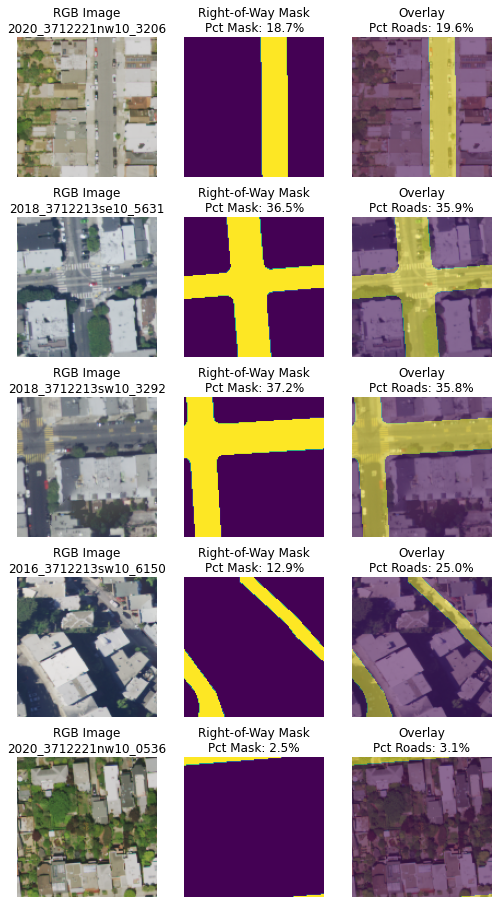

In [41]:
import matplotlib.pyplot as plt
cols, rows = 3, 5
axes = []
[[axes.append((c,r)) for r in range(rows)] for c  in range(cols)]
axis_count = len(axes)
fig, ax = plt.subplots(rows, cols, figsize=[8.5, 16])

no_diff_filt = (cut_df['pct_mask']==0)&(cut_df['roads']>.1)
rm_filt = (cut_df['mask_road_pct'].abs()<=1)|(cut_df['mask_road_diff'].abs()<=.15)
plot_filt = (rm_filt)&(cut_df['water']<0.5)&(~no_diff_filt) #&(cut_df['pct_roads']>0)
plot_cols = ['id', 'image', 'mask', 'pct_mask', 'roads', 'mask_road_pct']

for row, (id, focus_image, focus_mask, pct_mask, pct_roads, pct_diff) in enumerate(cut_df[plot_filt].sample(n=rows)[plot_cols].values):

    ax[row, 0].imshow(focus_image[:,:,:3])
    ax[row, 0].set_title('RGB Image' + '\n' + str(id))#'Size: {}x{}x{}'.format(focus_image.shape[0], focus_image.shape[1], focus_image.shape[2]))
    ax[row, 1].imshow(focus_mask)
    ax[row, 1].set_title('Right-of-Way Mask' + '\n' + 'Pct Mask: {0:.1%}'.format(pct_mask))
    ax[row, 2].imshow(focus_image[:,:,:3])
    ax[row, 2].imshow(focus_mask, alpha=.5)
    #ax[row, 2].set_title('Pct Roads: {0:.1%}'.format(pct_roads) + '\n' + 'Pct Diff: {0:.1%}'.format(pct_diff))
    ax[row, 2].set_title('Overlay' + '\n' + 'Pct Roads: {0:.1%}'.format(pct_roads))

    for col in range(cols):
        ax[row, col].set_axis_off()

## Export

In [42]:
no_diff_filt = (cut_df['pct_mask']==0)&(cut_df['roads']>.1)
rm_filt = (cut_df['mask_road_pct'].abs()<=1)|(cut_df['mask_road_diff'].abs()<=.15)
plot_filt = (rm_filt)&(cut_df['water']<0.5)&(~no_diff_filt)

In [48]:
bands = 4
img_arr = np.vstack(cut_df[plot_filt&(cut_df['year']==2018)]['image'].values)
nsamples = int(img_arr.shape[0]/128)
sample_shape = (nsamples, 128, 128, bands)
img_arr = img_arr.reshape(nsamples, 128*128*bands)
img_arr = pd.DataFrame(img_arr)#.astype(int)

In [49]:
bands = 1
mask_arr = np.vstack(cut_df[plot_filt&(cut_df['year']==2018)]['mask'].values)
nsamples = int(mask_arr.shape[0]/128)
sample_shape = (nsamples, 128, 128, bands)
mask_arr = mask_arr.reshape(nsamples, 128*128*bands)
mask_arr = pd.DataFrame(mask_arr)#.astype(int)

In [50]:
info_df = cut_df[plot_filt&(cut_df['year']==2018)][[c for c in list(cut_df) if c not in ['image','mask']]].copy()

In [52]:
#import pyarrow as pa
#import pyarrow.parquet as pq

#path = os.path.join(DATA_DIR, 'clean', 'sf_naip_2016_2020.parquet')
#pq.write_table(pa.Table.from_pandas(final_df), path)
#path = os.path.join(DATA_DIR, 'clean', 'sf_naip_2016_2020.csv')
#final_df.to_csv(path)

#for year in [2016, 2018, 2020]:
    #path = os.path.join(DATA_DIR, 'clean', 'sf_naip_{}.json'.format(year))    
    #cut_df[plot_filt&(cut_df['year']==int(year))].to_json(path)
    #path = os.path.join(DATA_DIR, 'clean', 'sf_naip_{}.csv'.format(year))    
    #cut_df[plot_filt&(cut_df['year']==int(year))].to_csv(path)

#with open(path, "w+") as output_file:
    
path = os.path.join(DATA_DIR, 'clean', 'sf_naip_images.parquet')
img_arr.rename(columns={c:str(c) for c in list(img_arr)}).to_parquet(path)

In [53]:
path = os.path.join(DATA_DIR, 'clean', 'sf_naip_mask.parquet')
mask_arr.rename(columns={c:str(c) for c in list(img_arr)}).to_parquet(path)

path = os.path.join(DATA_DIR, 'clean', 'sf_naip_info.parquet')
info_df.rename(columns={c:str(c) for c in list(img_arr)}).to_parquet(path)